# Covid 19 experiments


In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pathlib, json
import torch
import os
import pandas as pd
import numpy as np
import pickle, sys
import warnings
from tqdm import tqdm
from sklearn.model_selection import KFold

sys.path.append('../')
sys.path.append('../../')

from recipes.dataset import MCPASDataset
import warnings
warnings.filterwarnings('ignore')

# from analysis_util import display_mat_from_ind
# from analysis_util import convert_len

from Bio.PDB import *

from pdb_util import get_chain_list, calc_dist, remove_HOH #, get_structure_from_id
# get_structure_from_id, from_str_to_chain_names, get_residues_from_names
# from pdb_util import get_cdrs_from_anarci
# from pdb_util import get_seqs_from_residues
warnings.filterwarnings(action='once')


def display_mat_from_ind(ind, wantdisplay=False):
    attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]
    aseq = DF_TCR.iloc[ind]['tcra']
    bseq = DF_TCR.iloc[ind]['tcrb']
    abseq = convert_len(aseq, MAXLENGTH_A) + convert_len(bseq, MAXLENGTH_B)
    peptide = convert_len(DF_TCR.iloc[ind]['peptide'], max_len_epitope)

    attn_output_weights2_list = []
    for head_i in range(4):
        a = attn_output_weights2[head_i]
        dfa = pd.DataFrame(a)
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.columns = [f'{c}_{i}' for i,c in enumerate(list(abseq_with_comma))]
        dfa = dfa.head(len(peptide.replace('8','')))
        dfa.index = list(peptide.replace('8',''))
        dfa.index = [f'{ind}_{i}' for i,ind in enumerate(dfa.index)]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights2_list.append(dfa)

    abseq_index = convert_len(aseq, MAXLENGTH_A) + ':' + convert_len(bseq, MAXLENGTH_B)

    attn_output_weights1_list = []
    for head_i in range(4):
        a = attn_output_weights1[head_i]
        dfa = pd.DataFrame(a).T
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.T
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(list(abseq_index))]

        dfa.columns = [f'{ind}_{i}' for i,ind in enumerate(peptide)]
        selector_columns = [c for c in dfa.columns if '8_' not in c]
        selector_index = [c for c in dfa.index if '8_' not in c]
        dfa = dfa.loc[selector_index]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(abseq_with_comma)]
        dfa = dfa[selector_columns]
        if wantdisplay:
            display(px.imshow(dfa, width=800, height=480))
        attn_output_weights1_list.append(dfa)
    return attn_output_weights1_list, attn_output_weights2_list

def convert_len(seq, maxlen):
    if len(seq) >= maxlen:
        return seq[:maxlen]
    else:  # padding
        pad = '8' * int(maxlen - len(seq))
        return seq + pad
    


def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk


def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

def split_and_get_first(a):
    if ',' in a:
        a = a.split(',')[0]
    return a


In [3]:
!ls ../data/

all_tcrs_a.fasta         jem_20211327_tables3.csv
all_tcrs_b.fasta         tcr_with_crystal.csv


# Data

In [4]:
jem_20211327_tables3 = pd.read_csv('../data/jem_20211327_tables3.csv')

In [5]:
jem_20211327_tables3

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
0,DB2_CAGGTGCTCTCCGGTT,8,Ts-017,recombinant S protein,Ts-017,4,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-017,0.0636,0.1352,1.0874,50.0,191.0,-5.3578,-5.2351,0.1227,0.1081
1,DB3_CGATTGAGTTACTGAC,8,Ts-018,inactivated virus,Ts-018,2,TRAV12-3,CAMTYSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
2,DB2_TGAGCCGGTAGAGCTG,8,Ts-017,Peptide pool S,Ts-017,4,TRAV21,CALKGSDYKLSF,TRAJ20,TRAC,...,NaN,0.0038,0.0510,3.7388,3.0,72.0,-5.3972,-4.7881,0.6091,0.1516
3,DB10_TTGCGTCTCTCGATGA,8,Ts-025#2,recombinant S protein,Ts-025,2,TRAV22,CAVDSGTSYGKLTF,TRAJ52,TRAC,...,NaN,0.2099,0.1734,-0.2758,165.0,245.0,-5.3819,-5.3901,-0.0082,0.8317
4,DB10_GTGCATATCGACGGAA,8,Ts-025,recombinant S protein,Ts-025,2,TRAV12-3,CAMTPSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,DB7_ACTTGTTAGCCTTGAT,8,Ts-010#2,recombinant S protein,Ts-010,3,TRAV8-6,CAVSSSGGTSYGKLTF,TRAJ52,TRAC,...,NaN,0.0013,0.0050,1.9612,1.0,7.0,-5.8426,-5.6858,0.1568,NaN
1880,DB7_ACTGCTCTCCCAAGAT,8,Ts-010,inactivated virus,Ts-010,3,TRAV2,CAVGADYKLSF,TRAJ20,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881,DB7_ACGTCAAGTGAGTGAC,8,Ts-010,Peptide pool S,Ts-010,3,TRAV8-4,CAVSRYGAGGGNKLTF,TRAJ10,TRAC,...,NaN,0.0013,0.0000,-inf,1.0,0.0,-5.4795,NaN,NaN,NaN
1882,DB7_ACGGGTCGTACCATCA,8,Ts-010,Peptide pool M+N,Ts-010,3,TRAV12-1,CVVNPQGSGNTGKLIF,TRAJ37,TRAC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_clonotypes10 = jem_20211327_tables3[jem_20211327_tables3['Public clonotype in Figure 3A'].notna()]
df_clonotypes10 = df_clonotypes10.drop_duplicates(subset=['CDR3.alpha', 'CDR3.beta'])
df_clonotypes10 = df_clonotypes10.sort_values(by=['Public clonotype in Figure 3A']).dropna()
df_clonotypes10[['CDR3.alpha', 'CDR3.beta', 'Public clonotype in Figure 3A']]
df_clonotypes10

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
60,DB9_ACACCAACAATGTAAG,8,Ts-009,inactivated virus,Ts-009,4,TRAV2,CAALNAGNMLTF,TRAJ39,TRAC,...,#1,0.0064,0.0616,3.2749,5.0,87.0,-5.4312,-5.1065,0.3247,0.1998
1366,DB3_TCAGGTAGTGGCAAAC,8,Ts-018,Peptide pool S,Ts-018,2,TRAV8-2,CVVSRTGGGNKLTF,TRAJ10,TRAC,...,#1,0.1399,0.2088,0.5771,110.0,295.0,-5.3877,-5.0642,0.3235,0.0000
666,DB10_GTTCGGGCAAACCCAT,8,Ts-025,Peptide pool S,Ts-025,2,TRAV13-1,CAAGYALNF,TRAJ41,TRAC,...,#10,0.0153,0.0248,0.6982,12.0,35.0,-5.5338,-5.2348,0.2990,0.0284
795,DB9_GTGCGGTCAGTTTACG,8,Ts-009#2,recombinant S protein,Ts-009,4,TRAV12-1,CVVNKGSSASKIIF,TRAJ3,TRAC,...,#2,0.0305,0.1380,2.1762,24.0,195.0,-5.4218,-4.6512,0.7706,0.0000
1,DB3_CGATTGAGTTACTGAC,8,Ts-018,inactivated virus,Ts-018,2,TRAV12-3,CAMTYSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
4,DB10_GTGCATATCGACGGAA,8,Ts-025,recombinant S protein,Ts-025,2,TRAV12-3,CAMTPSGGYQKVTF,TRAJ13,TRAC,...,#3,0.0598,0.1507,1.3340,47.0,213.0,-5.4960,-5.1993,0.2967,0.0001
577,DB10_GACTGCGCACCATCCT,8,Ts-025,recombinant S protein,Ts-025,2,TRAV8-4,CAVSDQGRDDKIIF,TRAJ30,TRAC,...,#4,0.0204,0.1656,3.0242,16.0,234.0,-5.4771,-5.0026,0.4746,0.0003
0,DB2_CAGGTGCTCTCCGGTT,8,Ts-017,recombinant S protein,Ts-017,4,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-017,0.0636,0.1352,1.0874,50.0,191.0,-5.3578,-5.2351,0.1227,0.1081
1372,DB3_TACAGTGCAGGAATCG,8,Ts-018,Peptide pool S,Ts-018,2,TRAV12-1,CVVNRGSSYKLIF,TRAJ12,TRAC,...,#5 TCR-018,0.1221,0.1529,0.3238,96.0,216.0,-5.4360,-5.3380,0.0979,0.0286
1021,DB4_TCAGCAATCTGGGCCA,8,Ts-002#2,Peptide pool S,Ts-002,4,TRAV13-2,CAENSGGSNYKLTF,TRAJ53,TRAC,...,#6,0.0153,0.0878,2.5231,12.0,124.0,-5.4641,-5.0426,0.4215,0.0063


# Model

In [7]:
# dt = "20211029_011638" #logdf.checkp[0].split('/')[-1]

dt = '20220211_191954'

In [8]:
!find ./ -name "20220211_191954_attention_matrix_dict.pickle"

In [9]:
AACODES = pd.read_csv('../analysis/aa_codes.csv')
AACODES['Abbreviation'] = AACODES['Abbreviation'].apply(lambda a: a.upper())
AACODES_DICT = {row['Abbreviation']:row['1 letter abbreviation'] for i, row in AACODES.iterrows()}
KFOLD_I = 0

print('dt', dt)
OUT_DIR = '../analysis/../../../tcr_attention_cachedir'
ATTENTION_MATRIX_DICT = pickle.load(open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle','rb'))
# attn_output_weights1, attn_output_weights2, abseq_with_comma, peptide, ypred, sign = ATTENTION_MATRIX_DICT[ind]

# p_list = [f"../analysis/../../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
#           f"../analysis/../../external_data/ERGO-II/Samples/mcpas_train_samples.pickle", 
#           f'../analysis/../../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle',
#           f'../analysis/../../external_data/ERGO-II/Samples/mcpas_test_samples.pickle',]
# df_all = get_df_from_path(p_list)

# print("df_all(train).value_counts() \n\t", df_all.sign.value_counts().to_dict())
# kf = KFold(n_splits=5, shuffle=True, random_state=2)
# train_index, valid_index = [
#     (train_index, valid_index) for train_index, valid_index in kf.split(df_all)
# ][KFOLD_I]
# df_train, df_valid = df_all.loc[train_index], df_all.loc[valid_index]

# DF_TCR = df_train = remove_UNK_and_take_subset(df_train)
# dataset_train, dataset_valid = MCPASDataset(df_train), MCPASDataset(df_valid)

# print('len(dataset_train),', len(dataset_train), len(df_train))


dt 20220211_191954


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_5461/137843703.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='../analysis/../../../tcr_attention_cachedir/20220211_191954_attention_matrix_dict.pickle'>
  ATTENTION_MATRIX_DICT = pickle.load(open(f'{OUT_DIR}/{dt}_attention_matrix_dict.pickle','rb'))


In [10]:
with open(f"../analysis/../hpo_params/optuna_best.json", "r") as fp:
    hparams = json.load(fp)

# Get model and dataloader 


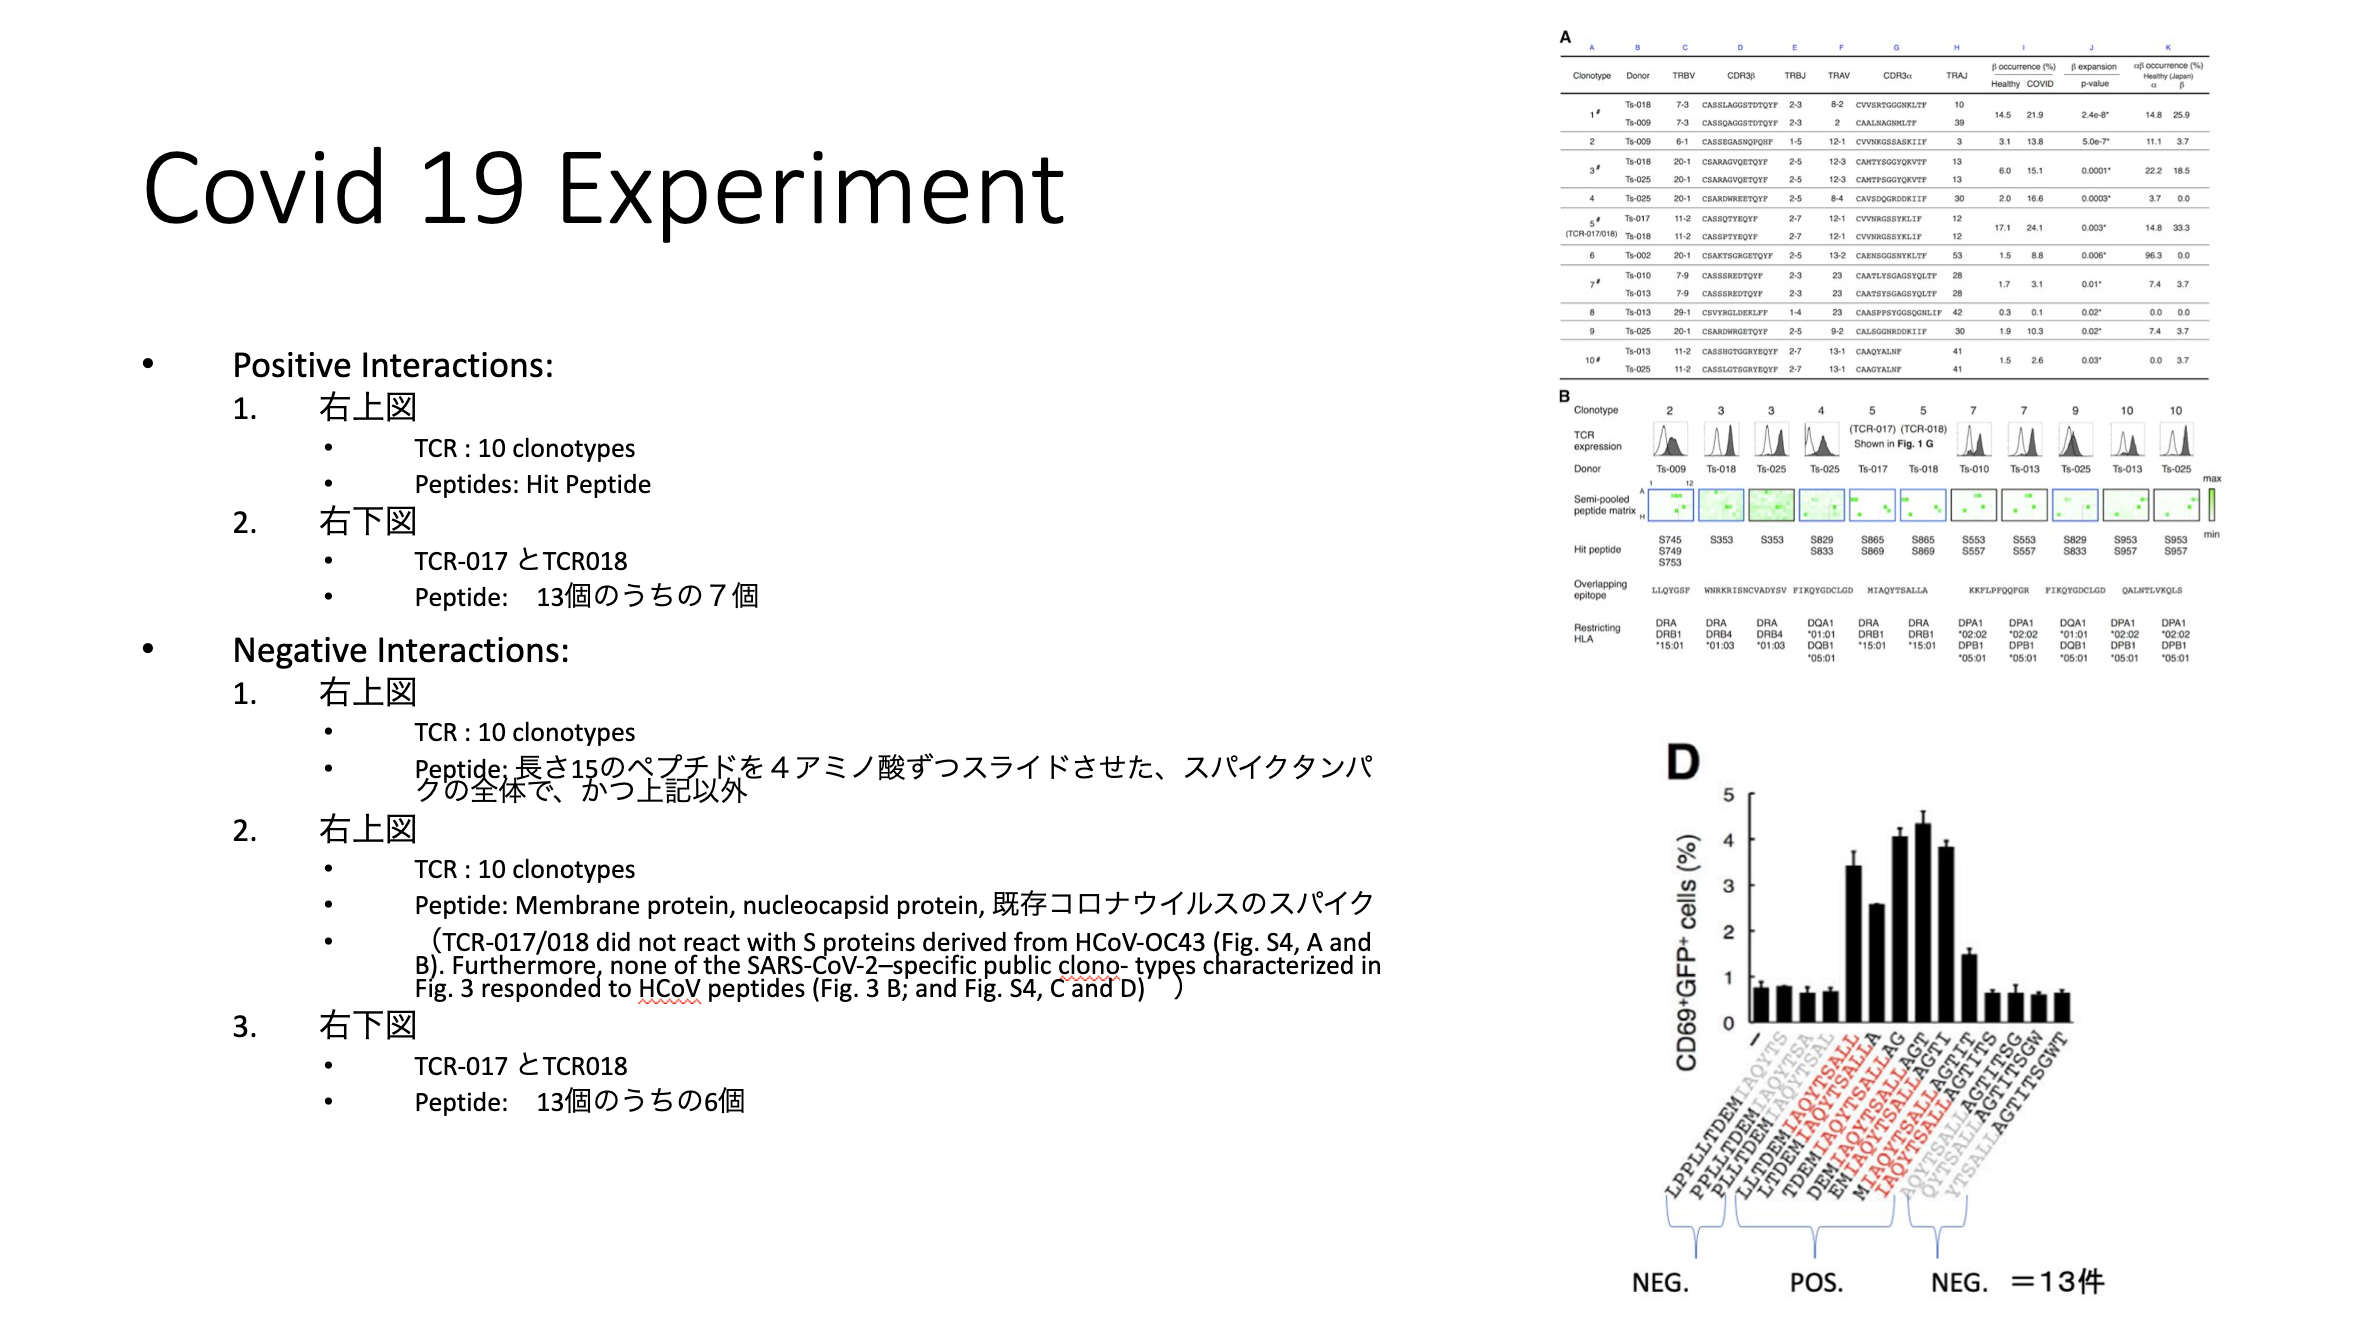
https://rupress.org/jem/article/218/12/e20211327/212701/

In [11]:
all_spike_protein = '''
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS
NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV
NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE
GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT
LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK
CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN
CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD
YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC
NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN
FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP
GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY
ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI
SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE
VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC
LGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAM
QMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN
TLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA
SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPA
ICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDP
LQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDL
QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD
SEPVLKGVKLHYT
'''.replace('\n','')

# Spike
https://rest.uniprot.org/uniprotkb/P0DTC2.fasta

In [12]:
df_clonotypes10['Public clonotype in Figure 3A'].unique()

array(['#1', '#10', '#2', '#3', '#4', '#5 TCR-017', '#5 TCR-018', '#6',
       '#7', '#8', '#9'], dtype=object)

In [13]:
df_clonotypes10.head(2)

,Seurat barcode,GEX.Cluster,Patient.ID,Stimulation,Patient,Patient.Disease Severity,TRAV,CDR3.alpha,TRAJ,TRAC,...,Public clonotype in Figure 3A,Occurrence in Healthy,Occurrence in Covid19,log2(Occurrence in Covid19 / Healthy),#Patients in Healthy,#Patients in Covid19,avg.log10(Expansion) in Healthy,avg.log10(Expansion) in Covid19,log10Expansion (Covid19 - Healthy),p-val
60,DB9_ACACCAACAATGTAAG,8,Ts-009,inactivated virus,Ts-009,4,TRAV2,CAALNAGNMLTF,TRAJ39,TRAC,...,#1,0.0064,0.0616,3.2749,5.0,87.0,-5.4312,-5.1065,0.3247,0.1998
1366,DB3_TCAGGTAGTGGCAAAC,8,Ts-018,Peptide pool S,Ts-018,2,TRAV8-2,CVVSRTGGGNKLTF,TRAJ10,TRAC,...,#1,0.1399,0.2088,0.5771,110.0,295.0,-5.3877,-5.0642,0.3235,0.0000


In [14]:
DICT_TARGET_PEPTIDE = {}
for i in [745, 749, 753, # 2
          353,  # 3
          829,833, # 4
          865,869, # 5
          553,557, # 7
          829,833,  # 9
          953,957,  # 10
         ]:
    DICT_TARGET_PEPTIDE[i] = all_spike_protein[i-1:i-1+15]

DICT_clonotype_to_HITpeptide = {'#2':[745, 749, 753],
                                '#3':[353],
                                '#4':[829,833],
                                '#5':[865,869],
                                '#5 TCR-017':[865,869],
                                '#5 TCR-018':[865,869],
                                '#7':[553,557],
                                '#9':[829,833],
                                '#10':[953,957],
                                '#1':[],
                                '#6':[],
                                '#8':[],
                               }

In [15]:
df_clonotypes10['HIT Peptide num'] = df_clonotypes10['Public clonotype in Figure 3A'].map(DICT_clonotype_to_HITpeptide)
df_clonotypes10['HIT Peptide seq'] = df_clonotypes10['HIT Peptide num'].apply(lambda lis: [DICT_TARGET_PEPTIDE[i] for i in lis])



## df_pos1

`10 clonotypes` x `Hit peptides`

In [16]:
all_pos_interactions = []
for i, row in df_clonotypes10[['CDR3.alpha', 'CDR3.beta', 'HIT Peptide seq']].iterrows():
    for hit in row['HIT Peptide seq']:
        temp = (row['CDR3.alpha'], row['CDR3.beta'], hit)
        all_pos_interactions.append(temp)
        

df_pos1 = pd.DataFrame(all_pos_interactions, columns=['tcra','tcrb','peptide'])
df_pos1['sign'] = 1

## df_ clonotype5 _pos _neg


`clonotype #5` x `Hit peptides`

In [17]:
df_5 = df_clonotypes10[
    (df_clonotypes10["Public clonotype in Figure 3A"]=="#5 TCR-017") |
    (df_clonotypes10["Public clonotype in Figure 3A"]=="#5 TCR-018")].copy()

TOTAL_PEPTIDE = 'LPPLLTDEMIAQYTSALLAGTITSGWT'

all_epitopes = [TOTAL_PEPTIDE[i:i+15] for i in range(13)]

positive_epitopes = all_epitopes[3:10]
negative_epitopes = all_epitopes[:3] + all_epitopes[10:]


df_list = []

for peptide in positive_epitopes:
    df_5['peptide'] = peptide
    df_5['sign'] = 1.0
    df_list.append(df_5.copy())
    
for peptide in negative_epitopes:
    df_5['peptide'] = peptide
    df_5['sign'] = 0.0
    df_list.append(df_5.copy())

df_5_posneg = pd.concat(df_list).rename(columns={'CDR3.alpha':'tcra', 'CDR3.beta':'tcrb'}).copy()

all_pos_interactions = all_pos_interactions + df_5_posneg.query('sign==1.0')[['tcra','tcrb','peptide']].apply(tuple, axis=1).values.tolist()


## df_neg1


`10 clonotypes` x `Spike peptides other than the Hit `

In [18]:
all_neg_interactions = []
for i in range(len(all_spike_protein)):
    if i+15 > len(all_spike_protein):
        continue
    if i%4==0:
        pep = all_spike_protein[i:i+15]
        if len(pep)<15:continue
        for i, row in df_clonotypes10.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_interactions.append(temp)


df_neg1 = pd.DataFrame(all_neg_interactions, columns=['tcra','tcrb','peptide'])
df_neg1['sign'] = 0.0

## df_neg2 (Other covids)


`clonotype #5` x `Other covide peptides`

In [19]:

negative_other_covid = [
    'RMAMYTGSLIG',
    'OISGYTLAATS',
    'QISGYTTAATV',
    'RMAMYTGSLIG',

    'LKQYTSA',
    'LVEYGSF',
    'LSEYGTF',
    'LKQYTSA',

    'YYQHTDINFT-----—',
    'WERKTFSNCNENMSS',
    'WERKIFSNCNFNLST',
    'YHKHTFIVLY-----',

    'TVDVDYKSCTKG',
    'FVE-AYNNCTGG',
    'FVE-AYNNCTGG',
    'TVDADYKKCTKG',

    'QSLAGG---ITY',
    'ATYYNSWQNLLY',
    'AVYYNSWQNLLY',
    'DTFLNG---ITY',

    'SALNHLTSQLR',
    'EALNNLLQQLS',
    'QALNSLLQQLF',
    'NSLNHLTSQLR',]

negative_other_covid = [n.replace('-','') for n in negative_other_covid]

df_list = []
df = df_clonotypes10.rename(columns={'CDR3.alpha':'tcra', 'CDR3.beta':'tcrb'}).copy()

for peptide in negative_other_covid:
    df['peptide'] = peptide
    df['sign'] = 0.0
    df_list.append(df.copy())

df_neg2 = pd.concat(df_list)


## df_n protein _neg

In [20]:
N_PROTEIN = """msdngpqnqr napritfggp sdstgsnqng ersgarskqr rpqglpnnta swftaltqhg
kedlkfprgq gvpintnssp ddqigyyrra trrirggdgk mkdlsprwyf yylgtgpeag
lpygankdgi iwvategaln tpkdhigtrn pannaaivlq lpqgttlpkg fyaegsrggs
qassrsssrs rnssrnstpg ssrgtsparm agnggdaala lllldrlnql eskmsgkgqq
qqgqtvtkks aaeaskkprq krtatkaynv tqafgrrgpe qtqgnfgdqe lirqgtdykh
wpqiaqfaps asaffgmsri gmevtpsgtw ltytgaikld dkdpnfkdqv illnkhiday
ktfpptepkk dkkkkadetq alpqrqkkqq tvtllpaadl ddfskqlqqs mssadstqa""".replace(' ','').replace('\n','').upper()


df_jem_tcrs = jem_20211327_tables3.dropna(subset=['CDR3.alpha', 'CDR3.beta'])

all_neg_N_PROTEIN = []
for i in range(len(N_PROTEIN)):
    if i+15 > len(all_spike_protein):
        continue
    if i%4==0:
        pep = N_PROTEIN[i:i+15]
        if len(pep)<15:continue
        for i, row in df_jem_tcrs.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_N_PROTEIN.append(temp)

df_neg3 = pd.DataFrame(all_neg_N_PROTEIN, columns=['tcra','tcrb','peptide'])
df_neg3['sign'] = 0.0

## df_m protein _neg

In [21]:
M_PROTEIN = """madsngtitv eelkklleqw nlvigflflt wicllqfaya nrnrflyiik liflwllwpv
tlacfvlaav yrinwitggi aiamaclvgl mwlsyfiasf rlfartrsmw sfnpetnill
nvplhgtilt rplleselvi gavilrghlr iaghhlgrcd ikdlpkeitv atsrtlsyyk
lgasqrvagd sgfaaysryr ignyklntdh ssssdniall vq""".replace(' ','').replace('\n','').upper()

all_neg_M_PROTEIN = []
for i in range(len(M_PROTEIN)):
    if i+15 > len(all_spike_protein):
        continue
    if i%4==0:
        pep = M_PROTEIN[i:i+15]
        if len(pep)<15:continue
        for i, row in df_jem_tcrs.iterrows():
            temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
            if temp in all_pos_interactions:
                pass
            else:
                all_neg_M_PROTEIN.append(temp)
                
df_neg4 = pd.DataFrame(all_neg_M_PROTEIN, columns=['tcra','tcrb','peptide'])
df_neg4['sign'] = 0.0

## df_s protein_neg

In [22]:
# all_neg_S_protein = []
# for i in range(len(all_spike_protein)):
#     if i+15 > len(all_spike_protein):
#         continue
#     if i%4==0:
#         pep = all_spike_protein[i:i+15]
#         if len(pep)<15:continue
#         for i, row in df_jem_tcrs.iterrows():
#             temp = (row['CDR3.alpha'], row['CDR3.beta'], pep)
            
#             if temp in all_pos_interactions:
#                 pass
#             else:
#                 all_neg_S_protein.append(temp)

# df_neg5 = pd.DataFrame(all_neg_S_protein, columns=['tcra','tcrb','peptide'])
# df_neg5['sign'] = 0.0

# Pos Neg Count

In [23]:
len(positive_epitopes), len(negative_epitopes) , len(negative_other_covid)

(7, 6, 24)

In [24]:
for d in [df_5_posneg, df_pos1, df_neg1, df_neg2]:
    print(d.shape)

(26, 29)
(19, 4)
(4391, 4)
(336, 29)


In [27]:
df_5_posneg.columns

Index(['Seurat barcode', 'GEX.Cluster', 'Patient.ID', 'Stimulation', 'Patient',
       'Patient.Disease Severity', 'TRAV', 'tcra', 'TRAJ', 'TRAC', 'TRBV',
       'tcrb', 'TRBJ', 'TRBC', 'V_CDR3_J', 'Public clonotype in Figure 3A',
       'Occurrence in Healthy', 'Occurrence in Covid19',
       'log2(Occurrence in Covid19 / Healthy)', '#Patients in Healthy',
       '#Patients in Covid19', 'avg.log10(Expansion) in Healthy',
       'avg.log10(Expansion) in Covid19', 'log10Expansion (Covid19 - Healthy)',
       'p-val', 'HIT Peptide num', 'HIT Peptide seq', 'peptide', 'sign'],
      dtype='object')

In [26]:
dfall = pd.concat([df_5_posneg, df_pos1, df_neg1, df_neg2, df_neg3, df_neg4])
dfall = dfall.drop_duplicates(subset=['tcra','tcrb','peptide','sign'])
dfall = dfall.reset_index(drop=True)

In [28]:
dfall.sign.value_counts()

0.0    786327
1.0        29
Name: sign, dtype: int64

In [29]:
torch_dataset = MCPASDataset(dfall)
analysis_loader = torch.utils.data.DataLoader(torch_dataset, shuffle=False, batch_size=32)

datasize and y-vcounts:  (786356, 29) 0    786327
1        29
Name: sign, dtype: int64


In [30]:
len(analysis_loader)

24574

## Recover model weights

In [31]:
from recipes.utils import get_file_paths
from scripts.attention_extractor import get_attention_weights, Explain_TCRModel
from recipes.model import TCRModel
from ignite.handlers import Checkpoint
from ignite.engine import Events, create_supervised_trainer

n_tok = 29  # NUM_VOCAB
n_pos1 = 62  # MAX_LEN_AB
n_pos2 = 26  # MAX_LEN_Epitope
n_seg = 3

d_model, d_ff, n_head,n_local_encoder = hparams['d_model'], hparams['d_ff'], hparams['n_head'], hparams['n_local_encoder']
n_global_encoder = hparams['n_global_encoder']
dropout = hparams['dropout']
batch_size = hparams['batch_size']
lr=hparams['lr']

explain_model = Explain_TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                                 n_tok=n_tok, n_pos1=n_pos1, n_pos2=n_pos2, n_seg=n_seg)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

'''Model, optim, trainer'''
model = TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                 n_tok=n_tok, n_pos1=n_pos1,
                n_pos2=n_pos2, n_seg=n_seg)

# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Loss
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 15.0], device=device))

trainer = create_supervised_trainer(
    model=model, optimizer=optim, loss_fn=loss_fn, device=device,
)

checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if dt in f]
CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'
print(CHECKPOINT_DIR)
CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

## Get the prediction and the best model
to_load = {'model': model, 'optimizer': optim, 'trainer': trainer}

torch_check_point_local = '../../../checkpoint/'
fro = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATH)
if not os.path.exists(os.path.join(torch_check_point_local, CHECKPOINT_PATH)):
    os.system(f'''aws s3 cp {fro} {torch_check_point_local}''')
    
checkpoint = torch.load(os.path.join(torch_check_point_local, CHECKPOINT_PATH), map_location=torch.device(device))

checkpoint['trainer']['seed'] = 9

Checkpoint.load_objects(to_load=to_load, checkpoint=checkpoint)


s3://sg-playground-kkoyama-temp/tcrpred/checkpoint/20220211_191954


/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_5461/1470692941.py:40: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.2.102', 50770), raddr=('52.216.88.67', 443)>
  checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')


In [32]:
dfall['tcra'].apply(len).max(), dfall['tcrb'].apply(len).max(), dfall['peptide'].apply(len).max()

(20, 21, 15)

In [31]:
MAXLENGTH_A, MAXLENGTH_B, max_len_epitope = 28, 28, 25

def get_mat_from_result_tuple(result_tuple, aseq, bseq, peptide, showplot=False):
    #abseq = convert_len(aseq, MAXLENGTH_A)convert_len(bseq, MAXLENGTH_B) 
    attn_output_weights1 = result_tuple[0]
    attn_output_weights2 = result_tuple[1]
    # print(f"aseq={aseq}, bseq={bseq}, peptide={peptide}")
    abseq_with_comma = f'{aseq}:{bseq}'
    abseq_index = convert_len(aseq, MAXLENGTH_A) + ':' + convert_len(bseq, MAXLENGTH_B) 
    
    attn_output_weights2_list = []
    for head_i in range(4):
#         print('head', head_i, attn_output_weights2[head_i].shape)
        a = attn_output_weights2[head_i]
        dfa = pd.DataFrame(a)
        dfa.insert(27, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.columns = list(abseq_with_comma)
        dfa.columns = [f'{c}_{i}' for i,c in enumerate(dfa.columns)]
        dfa = dfa.head(len(peptide.replace('8','')))
        dfa.index = list(peptide.replace('8',''))
        dfa.index = [f'{ind}_{i}' for i,ind in enumerate(dfa.index)]    
        #         print('df.sum(axis=0)', dfa.sum(axis=0))
        #         print('df.sum(axis=1)', dfa.sum(axis=1))
        # display(px.imshow(dfa, width=800, height=480))
        
        if showplot:
            axs[0,head_i].imshow(dfa, aspect='equal')
            axs[0,head_i].set_xticks(range(len(dfa.columns)))
            axs[0,head_i].set_yticks(range(len(dfa.index)))
            axs[0,head_i].set_xticklabels(dfa.columns)
            axs[0,head_i].set_yticklabels(dfa.index)
        attn_output_weights2_list.append(dfa)
    
    attn_output_weights1_list = []
    for head_i in range(4):
#         print('head', head_i, attn_output_weights1[head_i].shape)
        a = attn_output_weights1[head_i]
        dfa = pd.DataFrame(a).T
        dfa.insert(MAXLENGTH_A, "delimiter", [0.1**9 for _ in range(len(dfa))])
        dfa = dfa.T
        dfa = dfa.loc[:, ((dfa!=0).sum()!=0).values]
        dfa.index = list(abseq_index)
        dfa.index = [f'{c}_{i}' for i,c in enumerate(dfa.index)]
        dfa.columns = list(convert_len(peptide, len(dfa.columns)))
        dfa.columns = [f'{ind}_{i}' for i,ind in enumerate(dfa.columns)]
        selector_columns = [c for c in dfa.columns if '8_' not in c]
        selector_index = [c for c in dfa.index if '8_' not in c]
        dfa = dfa.loc[selector_index]
        dfa.index = [f'{c}_{i}' for i,c in enumerate(abseq_with_comma)]
        dfa = dfa[selector_columns]
        
        if showplot:
            axs[1,head_i].imshow(dfa, aspect='equal')
            axs[1,head_i].set_xticks(range(len(dfa.columns)))
            axs[1,head_i].set_yticks(range(len(dfa.index)))
            axs[1,head_i].set_xticklabels(dfa.columns)
            axs[1,head_i].set_yticklabels(dfa.index)
        attn_output_weights1_list.append(dfa)
    return attn_output_weights1_list, attn_output_weights2_list

In [32]:
dfall.shape, len(analysis_loader)

((262826, 29), 8214)

In [33]:
dfall.index

RangeIndex(start=0, stop=262826, step=1)

In [34]:
(274558 * (2.20/4772) ) / 60, 'hours' # 4772 iteration, 2.20 mins

(2.10962419670299, 'hours')

In [35]:
for xx, yy in analysis_loader:
    break

In [36]:
from scipy.special import expit, softmax
softmax(model(xx).detach().numpy(), axis=1)[:,1].ravel()

array([4.3620709e-01, 2.4586927e-02, 2.0128277e-01, 7.5143687e-02,
       9.7494251e-01, 9.9002421e-01, 8.6224163e-01, 6.7647086e-03,
       9.9897915e-01, 9.9856740e-01, 9.9688232e-01, 9.9583137e-01,
       9.7545010e-01, 3.2477462e-01, 9.3356750e-05, 2.4682842e-04,
       9.6882047e-04, 3.9398954e-03, 9.8866898e-01, 9.5161754e-01,
       9.8865038e-01, 9.9935573e-01, 9.9766791e-01, 5.8462691e-01,
       5.9207928e-01, 2.7645530e-02, 1.8007752e-02, 8.8697505e-01,
       5.6292816e-07, 7.4734453e-06, 6.6379532e-02, 3.8950336e-09],
      dtype=float32)

In [37]:
import torch
model = model.eval()

ret_list = []
for (xx,yy) in tqdm(analysis_loader):
    with torch.no_grad():
        ret = softmax(model(xx).detach().numpy(), axis=1)[:,1].ravel()
    ret_list.append(ret)
    
ret_list = np.concatenate(ret_list)

100%|████████████████| 8214/8214 [17:25<00:00,  7.86it/s]


In [38]:
!ls "../analysis/DICT_Result_Covid19"

20220211_191954_DICT_PDBID_2_Atten12.pickle
20220211_191954_DICT_PDBID_2_model_out.pickle
20220211_191954_df_ypred_result.pickle


In [39]:

dfall['ypred'] = ret_list
directory = "../analysis/DICT_Result_Covid19"

df_ypred_result = pd.DataFrame(ret_list)
df_ypred_result.to_pickle(f'{directory}/{dt}_df_ypred_result.pickle')

In [40]:
from matplotlib import pyplot as plt

showplt = False
HEAD_COUNT = 4
# DICT_PDBID_2_Atten12 = {}

# for p, (xx,yy) in tqdm(zip(dfall.index, analysis_loader)):
#     if p not in DICT_PDBID_2_model_out:
#         continue
#     a,b,e = dfall.loc[p][['tcra','tcrb','peptide']]
#     attn_output_weights1_list, attn_output_weights2_list = get_mat_from_result_tuple(
#         result_tuple=DICT_PDBID_2_model_out[p], aseq=a, bseq=b, peptide=e)
#     DICT_PDBID_2_Atten12[p] = (attn_output_weights1_list, attn_output_weights2_list)

In [41]:
# import pickle
# directory = "../analysis/DICT_Result_Covid19"
# os.system("mkdir ../analysis/DICT_Result_Covid19")

# for name, dic in zip(
#     [
#         "DICT_PDBID_2_Atten12",
#     ],
#     [
#         DICT_PDBID_2_Atten12,
#     ]):
#     pickle.dump(dic, open(f'{directory}/{dt}_{name}.pickle', 'wb'))


# Result

In [42]:
import pandas as pd

dt = '20220211_191954'
directory = "../analysis/DICT_Result_Covid19"

df_ypred_result = pd.read_pickle(f'{directory}/{dt}_df_ypred_result.pickle')

In [43]:
import matplotlib
import plotly.express as px

def visualize_mat(mat):
    fig, axs = plt.subplots(2,4, figsize=(20,8))
    for i in range(4):
        axs[0,i].imshow(mat[0][i], vmin=0, vmax=0.5)

    #fig, axs = plt.subplots(1,4, figsize=(20,4))
    for i in range(4):
        axs[1,i].imshow(mat[1][i], vmin=0, vmax=0.5)
    plt.show()

## Y Pred distribution

False    18
True     11
Name: ypred, dtype: int64
False    0.62069
True     0.37931
Name: ypred, dtype: float64


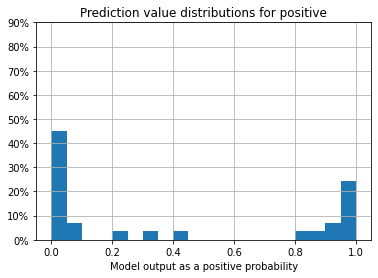

In [44]:
from matplotlib.ticker import PercentFormatter

temp = dfall.query('sign==1.0')
THH = 0.5
print(pd.value_counts(temp['ypred']>THH))
print(pd.value_counts(temp['ypred']>THH) / len(temp))

temp['ypred'].hist(bins=20, weights=np.ones(len(temp)) / len(temp))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Prediction value distributions for positive')
plt.ylim(0,.90)
plt.xlabel('Model output as a positive probability')
plt.show()


False    216012
True      46785
Name: ypred, dtype: int64
False    0.821973
True     0.178027
Name: ypred, dtype: float64


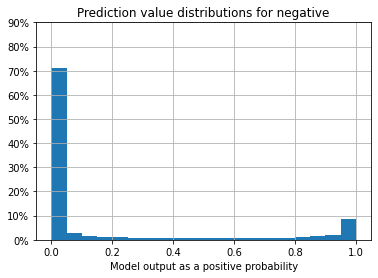

In [45]:
temp = dfall.query('sign==0.0')

print(pd.value_counts(temp['ypred']>THH) )

print(pd.value_counts(temp['ypred']>THH) / len(temp))

temp['ypred'].hist(bins=20, weights=np.ones(len(temp)) / len(temp))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Prediction value distributions for negative')
plt.ylim(0,.90)
plt.xlabel('Model output as a positive probability')
plt.show()


In [46]:
from sklearn.metrics import precision_score, recall_score

for THH in np.arange(0.5, 1.0, 0.05):
    p = precision_score(dfall.sign==1.0, dfall.ypred>THH)
    r = recall_score(dfall.sign==1.0, dfall.ypred>THH)
    print(f'{THH:.2f}', f'{p:.5f}', f'{r:.5f}')

0.50 0.00024 0.37931
0.55 0.00025 0.37931
0.60 0.00026 0.37931
0.65 0.00027 0.37931
0.70 0.00028 0.37931
0.75 0.00030 0.37931
0.80 0.00032 0.37931
0.85 0.00032 0.34483
0.90 0.00032 0.31034
0.95 0.00031 0.24138


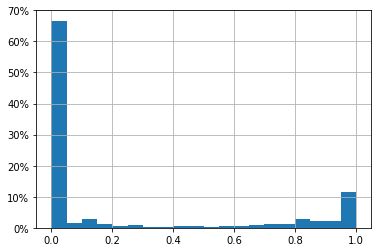

In [47]:
temp = dfall[dfall.peptide.isin(negative_other_covid)]
temp['ypred'].hist(bins=20, weights=np.ones(len(temp)) / len(temp))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

# Compare against training data

In [48]:
p_list = [
    "../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
    "../external_data/ERGO-II/Samples/mcpas_train_samples.pickle",
    "../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
    "../external_data/ERGO-II/Samples/mcpas_test_samples.pickle",
]

def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb")))

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

df_training = get_df_from_path(p_list)

/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_17138/1400341120.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../external_data/ERGO-II/Samples/vdjdb_train_samples.pickle'>
  return pd.DataFrame(pickle.load(open(datapath, "rb")))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_17138/1400341120.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../external_data/ERGO-II/Samples/mcpas_train_samples.pickle'>
  return pd.DataFrame(pickle.load(open(datapath, "rb")))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_17138/1400341120.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../external_data/ERGO-II/Samples/vdjdb_test_samples.pickle'>
  return pd.DataFrame(pickle.load(open(datapath, "rb")))
/var/folders/0t/4gd_k20d0_l07n5xyz8pvych0000gn/T/ipykernel_17138/1400341120.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../external_data/ERGO-II/Samples/mcpas_test_samples.pickle'>
  return pd.DataFrame(pickl

In [49]:
df_training.loc[df_training['peptide'].isin((positive_epitopes+negative_epitopes+negative_other_covid))]

,tcra,tcrb,va,ja,vb,jb,t_cell_type,peptide,protein,mhc,sign


In [50]:
df_training.loc[df_training['tcra'].isin(dfall.tcra)]['sign'].value_counts()

0    2744
1     539
Name: sign, dtype: int64

In [51]:
df_training.loc[df_training['tcrb'].isin(dfall.tcrb)]['sign'].value_counts()

0    2577
1     506
Name: sign, dtype: int64

In [52]:
jem_20211327_tables3['CDR3.alpha'].nunique()

1616

In [53]:
df_training.tcra.isin(jem_20211327_tables3['CDR3.alpha']).value_counts()

False    346295
True       3283
Name: tcra, dtype: int64

In [54]:
jem_20211327_tables3['CDR3.alpha'].isin(df_training.tcra).value_counts()

False    1726
True      158
Name: CDR3.alpha, dtype: int64

In [55]:
jem_20211327_tables3['CDR3.beta'].isin(df_training.tcrb).value_counts()

False    1855
True       29
Name: CDR3.beta, dtype: int64

In [56]:
pd.Series(jem_20211327_tables3['CDR3.alpha'].unique()).isin(df_training.tcra).value_counts()

False    1481
True      136
dtype: int64

In [57]:
pd.Series(jem_20211327_tables3['CDR3.beta'].unique()).isin(df_training.tcrb).value_counts()

False    1706
True       29
dtype: int64

In [58]:
df_training[['t_cell_type', 'sign']].value_counts()

t_cell_type  sign
MHCI         0       211827
CD8          0        58021
MHCI         1        42356
CD8          1        11577
MHCII        0         6898
CD4          0         4937
CD4,CD8      0         1985
MHCII        1         1389
CD4          1          971
CD4,CD8      1          414
dtype: int64

In [59]:
df_training[['t_cell_type']].value_counts()

t_cell_type
MHCI           254183
CD8             69598
MHCII            8287
CD4              5908
CD4,CD8          2399
dtype: int64